In [ ]:
# Pacotes úteis
import matplotlib.pyplot as plt  # para os gráficos
import numpy as np  # para operações matemáticas
from scipy.signal import find_peaks
from scipy import fft


# %matplotlib notebook
# %matplotlib ipympl

# opções de figuras
plt.rcParams["font.family"] = ["serif"]
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["text.usetex"] = True

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib ipympl


## Definição do Problema
Devemos simular a vibração de um poste de semáforo do tipo braço projetado que esteja balançando ao vento sob as condições presentes na avenida Dante Michelini, Vitória-ES.

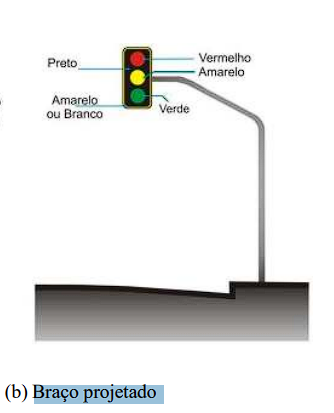



## Modelagem mátemática
<img src=croqui.svg width="500" length="500" style = "display:block; margin-left: auto; margin-right: auto">
As dimensões de postes do tipo estudado são:

| Simbolos | Dimensões|
|---|---|
| H | 5,5 m |
| L | 4,7 m |
| D | 0,114 m|
| t | 0,0045 m|

**O braço tem dimensões diferentes do poste engastado.

Foi escolhido utilizar um modelo de 6 graus de liberdade baseado na viga de Euler-Bernulli.
<img src=Frame1.svg width="800" style = "display: block; margin-left: auto; margin-right: auto">

#### Definido o modelo a ser adotado:

In [446]:
# Defininido as matrizes de massa, rigidez e transformação
def StiffnessFrame(E, A, I, L):
    """
    Calcula a matriz de rigidez de um elemento de pórtico.

    Parâmetros:
    E (float): Módulo de elasticidade do material.
    A (float): Área da seção transversal do elemento.
    I (float): Momento de inércia da seção transversal do elemento.
    L (float): Comprimento do elemento.

    Retorna:
    numpy.ndarray: Matriz de rigidez do elemento de pórtico.
    """
    K = (
        E
        * I
        / (L**3)
        * np.array([
            [A * (L**2) / I, 0, 0, -A * (L**2) / I, 0, 0],
            [0, 12, 6 * L, 0, -12, 6 * L],
            [0, 6 * L, 4 * (L**2), 0, -6 * L, 2 * (L**2)],
            [-A * (L**2) / I, 0, 0, A * (L**2) / I, 0, 0],
            [0, -12, -6 * L, 0, 12, -6 * L],
            [0, 6 * L, 2 * (L**2), 0, -6 * L, 4 * (L**2)],
        ])
    )
    return K


def MassFrame(rho, A, L):
    """
    Calcula a matriz de massa para um elemento de pórtico.

    Parâmetros:
    rho (float): Densidade do material.
    A (float): Área da seção transversal do elemento do pórtico.
    L (float): Comprimento do elemento do pórtico.

    Retorna:
    numpy.ndarray: Uma matriz de massa 6x6 para o elemento do pórtico.
    """
    M = (
        rho
        * A
        * L
        / (420)
        * np.array([
            [140, 0, 0, 70, 0, 0],
            [0, 156, 22 * L, 0, 54, -13 * L],
            [0, 22 * L, 4 * (L**2), 0, 13 * L, -3 * (L**2)],
            [70, 0, 0, 140, 0, 0],
            [0, 54, 13 * L, 0, 156, -22 * L],
            [0, -13 * L, -3 * (L**2), 0, -22 * L, 4 * (L**2)],
        ])
    )
    return M


def TransformationMatrix(s_theta, c_theta):
    """
    Gera uma matriz de transformação para um dado seno e cosseno de um ângulo.
    Parâmetros:
    s_theta (float): Seno do ângulo.
    c_theta (float): Cosseno do ângulo.
    Retorna:
    numpy.ndarray: Uma matriz de transformação 6x6.
    """
    T = np.array([
        [c_theta, s_theta, 0, 0, 0, 0],
        [-s_theta, c_theta, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, c_theta, s_theta, 0],
        [0, 0, 0, -s_theta, c_theta, 0],
        [0, 0, 0, 0, 0, 1],
    ])
    return T


In [447]:
# Propriedades mecânicas do poste (Aço SAE 1010).
E = 205e3  # Módulo de elasticidade (MPa)
rho = 7850  # Densidade (kg/m³)

# Dimensões do poste.
H = 4.90  # Altura (m)
L = 4.70  # Comprimento (m)
t = 0.0045  # Espessura (m)
D = 0.114  # Diâmetro (m)
A = np.pi * (D**2 - (D - 2 * t) ** 2) / 4  # Área (m²)
I = np.pi * (D**4 - (D - 2 * t) ** 4) / 64  # Inércia (m⁴)

# Dimensões do semáforo
m_sem = 15  # Massa (kg)
h = 1.1  # Altura (m)
l = 0.5  # largura (m)
I_sem = l * h**3 / 12  # Inércia de área (m⁴)
A_sem = l * h  # Área (m²)
J_sem = m_sem * h**2 / 12  # Inércia de massa (kg.m²)

##### Definindo as matrizes globais do modelo:

In [448]:
# Inicializa matrizes globais
n_elementos_vertical = 3
n_elementos_horizontal = 3
total_nos = n_elementos_vertical + n_elementos_horizontal + 1  # Nós totais
dofs = 3  # Graus de liberdade
total_dofs = dofs * total_nos
K = np.zeros((total_dofs, total_dofs))
M = np.zeros((total_dofs, total_dofs))


In [449]:
def initialize_section(
    K_global: np.ndarray,
    M_global: np.ndarray,
    start_node: int,
    n_elements: int,
    dofs: int,
    L_section: float,
    theta_deg: float,
    E: float,
    A: float,
    I: float,
    rho: float,
):
    """
    Adiciona uma seção de elementos à matriz global K e M.

    Parâmetros:
    K_global (np.ndarray): Matriz de rigidez global.
    M_global (np.ndarray): Matriz de massa global.
    start_node (int): Índice do nó inicial da seção.
    n_elements (int): Número de elementos na seção.
    dofs (int): Graus de liberdade por nó.
    L_section (float): Comprimento total da seção.
    theta_deg (float): Ângulo da seção em graus.
    E, A, I, rho: Propriedades do material e geométricas.

    Retorna:
    tuple: (K_global atualizada, M_global atualizada, novo_start_node)
    """
    theta = np.radians(theta_deg)
    c_theta = np.cos(theta)
    s_theta = np.sin(theta)
    T = TransformationMatrix(s_theta, c_theta)
    L_element = L_section / n_elements

    for i in range(n_elements):
        # Calcula as matrizes do elemento
        K_element = StiffnessFrame(E, A, I, L_element)
        M_element = MassFrame(rho, A, L_element)

        # Transforma para coordenadas globais
        K_element_global = T.T @ K_element @ T
        M_element_global = T.T @ M_element @ T

        # Índices na matriz global (6 DOFs por elemento)

        inicio = dofs * (start_node + i)
        fim = inicio + 2 * dofs

        # Monta na matriz global
        K_global[inicio:fim, inicio:fim] += K_element_global
        M_global[inicio:fim, inicio:fim] += M_element_global

    novo_start_node = start_node + n_elements
    return K_global, M_global, novo_start_node


# Adiciona seção vertical (ângulo 90°)
K, M, start_node = initialize_section(
    K, M, start_node=0, n_elements=n_elementos_vertical, dofs=dofs, L_section=4.90, theta_deg=90, E=E, A=A, I=I, rho=rho
)

# Adiciona seção horizontal (ângulo 0°)
K, M, _ = initialize_section(
    K,
    M,
    start_node=start_node,
    n_elements=n_elementos_horizontal,
    dofs=dofs,
    L_section=4.70,
    theta_deg=0,
    E=E,
    A=A,
    I=I,
    rho=rho,
)

# Adiciona massa do semáforo no último nó
M[-3, -3] += 15  # kg
M[-2, -2] += 15  # kg
M[-1, -1] += J_sem  # kg.m²


#### Condições de contorno:

##### Engastada:
$u_0$ = 0;

$u_1$ = 0;

$u_2$ = 0;

In [450]:
# Engastado no inicio.
K = np.delete(K, (0, 1, 2), axis=0)
K = np.delete(K, (0, 1, 2), axis=1)
M = np.delete(M, (0, 1, 2), axis=0)
M = np.delete(M, (0, 1, 2), axis=1)


### Amortecimento Proporcional


In [451]:
alpha = 0.01  # amortecimento proporcional
beta = 1e-7  # amortecimento proporcional

C = alpha * M + beta * K  # amortecimento proporcional


## Análise Modal


In [452]:
# 1: L^-1:
L_chol = np.linalg.cholesky(M)
L_chol_inv = np.linalg.inv(L_chol)

# 2: K_tiu
K_tiu = np.dot(L_chol_inv, np.dot(K, L_chol_inv.transpose()))

# 3: problema de autovalor
a, b = np.linalg.eig(K_tiu)  # a são autovalores e b autovetores (cada coluna de b é 1 autovetor)

wn = np.sqrt(a)  # vetor com as frequências naturais
v = b

# ordenar da menor para a maior frequência
v = v[:, np.argsort(wn)]
wn = np.sort(wn)

P = v  # a matriz P vai ser a própria matriz v que já contém todos os autovetores

S = np.dot(L_chol_inv.transpose(), P)  # da coordenada x para r
S_inv = np.dot(np.transpose(P), L_chol.transpose())  # da coordenada r para x

zeta_i = alpha / (2 * wn) + beta * wn / 2

print("Fatores de amortecimento:", zeta_i[0:4], "\n")
print("Frequências Naturais [Hz]:", wn[0:4] / 2 / np.pi, "\n")
# print("Frequências Naturais Analiticamente [Hz]:", w_alalitico / 2 / np.pi, "\n")


Fatores de amortecimento: [0.61087678 0.2237358  0.04350878 0.027848  ] 

Frequências Naturais [Hz]: [0.00130268 0.00355676 0.01828998 0.02857565] 



### Modos de Vibrar

In [453]:
# # Definição dos nós:
# Coordenadas dos nós verticais:
y_vertical = np.linspace(0, H, n_elementos_vertical + 1)  # [0, H/3, 2H/3, H]
x_vertical = np.zeros_like(y_vertical)  # [0, 0, 0, 0]

# Coordenadas dos nós horizontais:
x_horizontal = np.linspace(0, L, n_elementos_horizontal + 1)[1:]  # [L/4, L/2, 3L/4]
y_horizontal = np.full_like(x_horizontal, H)  # [H, H, H]

# Combina as coordenadas
x_nos = np.concatenate([x_vertical, x_horizontal])  # 7 nós
y_nos = np.concatenate([y_vertical, y_horizontal])  # 7 nós

print("nos x:\n", x_nos)
print("nos y:\n", y_nos)

nos x:
 [0.         0.         0.         0.         1.56666667 3.13333333
 4.7       ]
nos y:
 [0.         1.63333333 3.26666667 4.9        4.9        4.9
 4.9       ]


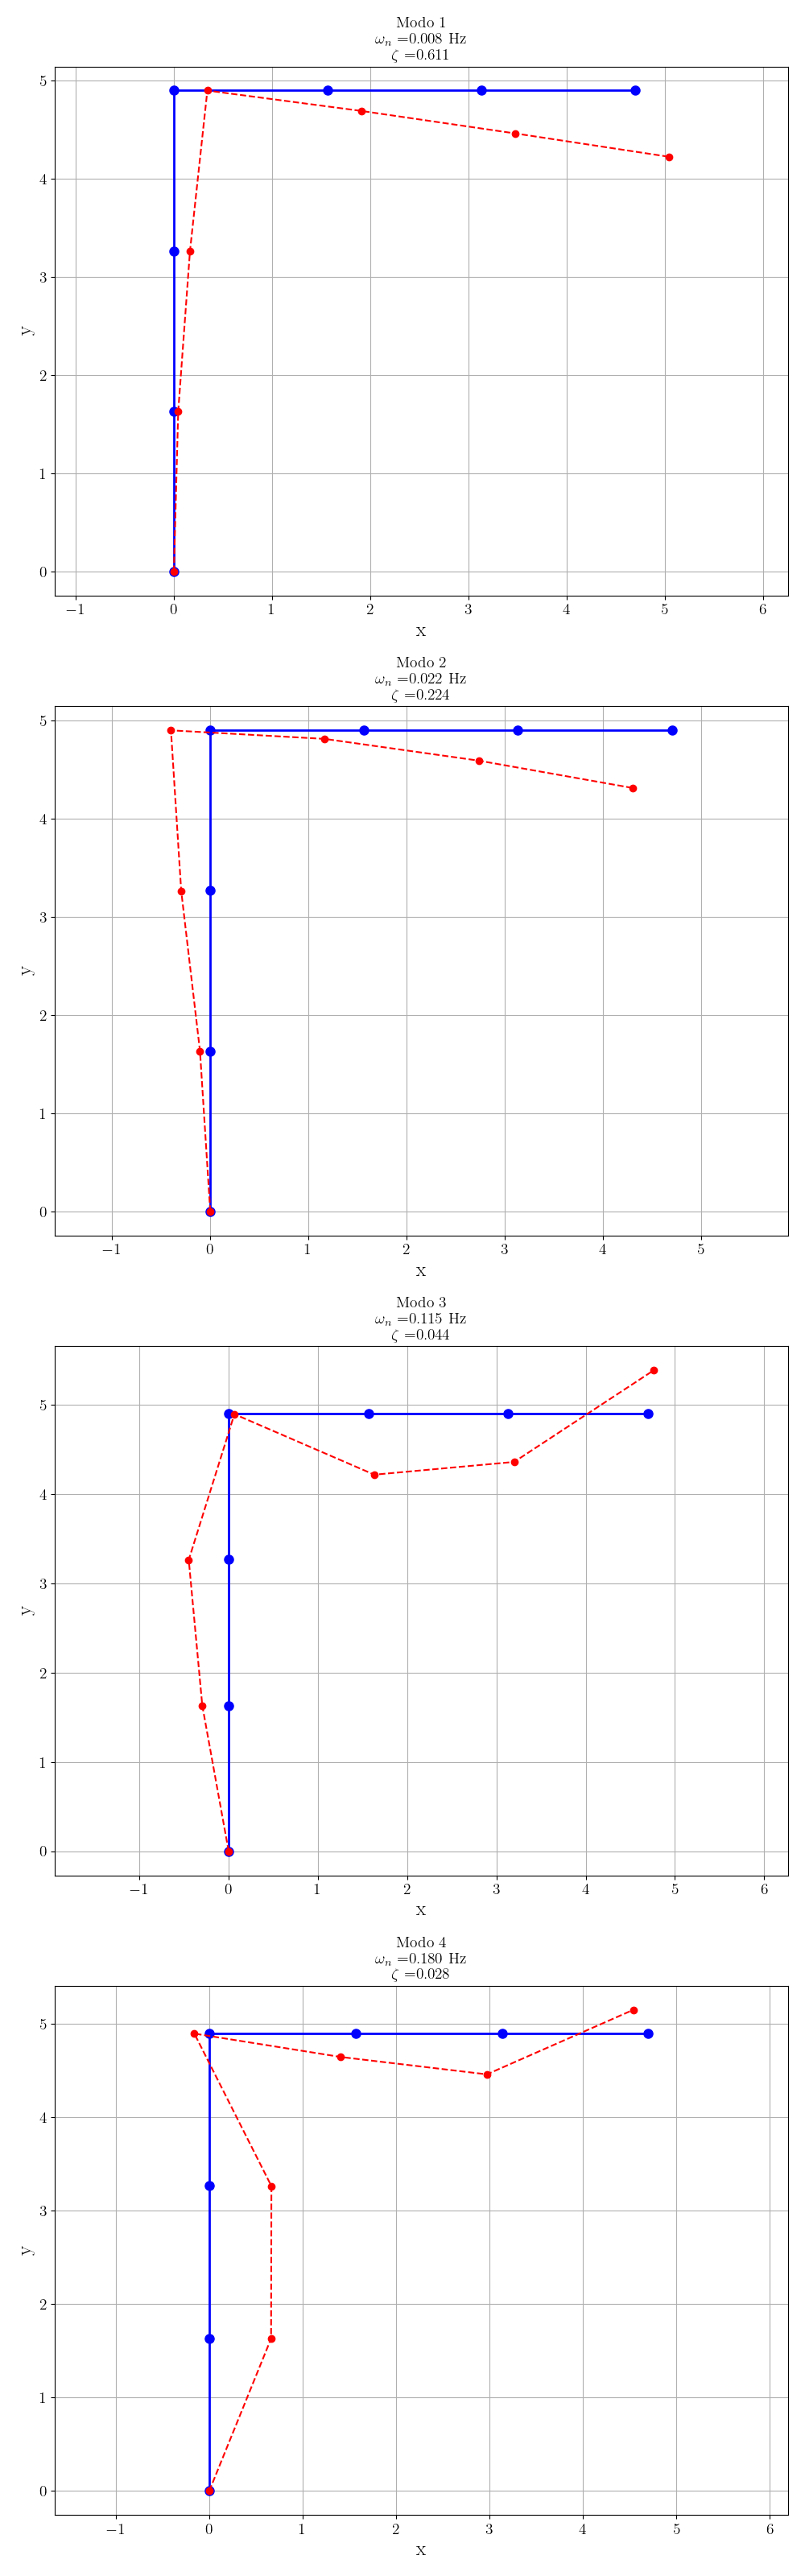

In [454]:
# # Plot dos modos de Vibrar
n_modos = 4
scale = 5  # Fator de escala para visualização

# Extrair deslocamentos em x e y
x_modo = np.zeros((total_nos - 1, n_modos))
y_modo = np.zeros((total_nos - 1, n_modos))

# Extrair deslocamentos (x, y, θ) para todos os modos
u_x = S[0::3, :n_modos]  # DOFs em x (shape: (total_nos, n_modos))
u_y = S[1::3, :n_modos]  # DOFs em y (shape: (total_nos, n_modos))


# Aplicar escala e ajustar dimensões para broadcasting
x_modo = x_nos[1:].reshape(-1, 1) + scale * u_x  # shape: (total_nos, n_modos)
y_modo = y_nos[1:].reshape(-1, 1) + scale * u_y

# Fixar o primeiro nó (suporte)
x_modo = np.insert(x_modo, 0, x_nos[0], axis=0)
y_modo = np.insert(y_modo, 0, y_nos[0], axis=0)

# Plotar
fig, axs = plt.subplots(n_modos, 1, figsize=(10, 8 * n_modos))
for i in range(n_modos):
    axs[i].plot(x_nos, y_nos, "-ob", linewidth=2, markersize=8, label="Nós")
    axs[i].plot(x_modo[:, i], y_modo[:, i], "--or", linewidth=1.5, markersize=6, label="Modo")
    axs[i].grid(True)
    axs[i].set_title(
        f"Modo {i + 1} \n" + r"$\omega_n$ =" + f"{wn[i]:.3f} Hz \n" + r"$\zeta$ =" + f"{zeta_i[i]:.3f}", fontsize=14
    )
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
    axs[i].axis("equal")

plt.tight_layout()
plt.show()


**Comentários:**
- Os modos aparentam estar condizentes com o esperado, conforme o comportamento descrito na literatura (apenas 1 nó no primeiro modo, 2 no segundo, assim em diante.)
- 


## Calculando as FRFs

#### **Função de Resposta em Frequência Analítica**


* $\mathbf{H}(j \omega) = [\mathbf{K} - \mathbf{M} \omega^2  + j \mathbf{C} \omega]^{-1}$


* $\mathbf{H}(j \omega)  =   \left[
\begin{matrix}
H_{11}(j \omega) & H_{12}(j \omega) \\
H_{21}(j \omega) & H_{22}(j \omega)
\end{matrix} \right]$

In [455]:
def calculate_frequency_response(M, C, K, w):
    """
    Calcula a resposta em frequência de um sistema de múltiplos graus de liberdade (MDoF).

    Parâmetros:
    ----------
    M : numpy.ndarray
        Matriz de massa (n x n).
    C : numpy.ndarray
        Matriz de amortecimento (n x n).
    K : numpy.ndarray
        Matriz de rigidez (n x n).
    w : numpy.ndarray
        Vetor de frequências em Hz.

    Retorno:
    -------
    H : numpy.ndarray
        Matriz de resposta em frequência (n x n x len(w)).
    """
    H = np.zeros((len(M), len(M), len(w)), dtype="complex")
    for n in range(0, len(w)):
        H[:, :, n] = np.linalg.inv(K - M * ((2 * np.pi * w[n]) ** 2) + complex(0, 1) * C * 2 * np.pi * w[n])
    return H


#### Definição dos parametros amostrais

In [482]:
# Definimos os parâmetros amostrais
fs = 10  # taxa de amostragem
Np = 100000  # número de pontos
tf = (Np) / fs  # tempo total
t = np.linspace(0, tf, Np, endpoint=False)
n_window = Np // 4
n_fft = n_window
overl = n_window // 5
janela = "hann"

In [457]:
# Estimamos a resposta em frequência:
w = np.linspace(0, fs / 2, int(Np / 2), endpoint=False)  # vetor freqência em Hz
Hw = calculate_frequency_response(M, C, K, w)

#### Plots da FRF:

In [458]:
xlim = (0, fs / 2 if fs < 2 else 2)
ylim = (1e-5, 100)

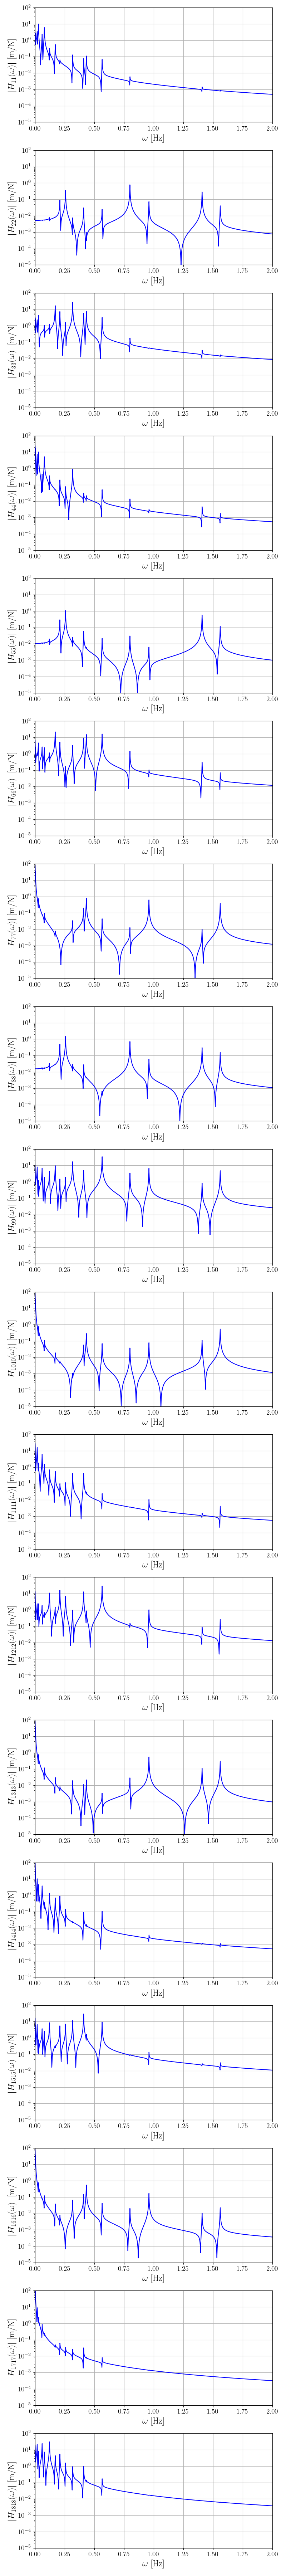

In [459]:
def plot_n_frf(w, H, diagonal_only=False, figsize=(6, 6), xlim=(0, 50), ylim=(1e-5, 1e-1), **plot_kwargs):
    """
    Plota a Função de Resposta em Frequência (FRF) para um sistema com n graus de liberdade.

    Parâmetros:
    ----------
    w : array-like
        Array de valores de frequência em Hz.
    H : ndarray
        Array multidimensional contendo os valores da FRF.
        H deve ter dimensões (n, n, len(w)), onde n é o número de graus de liberdade.
    diagonal_only : bool, opcional
        Se True, plota apenas a diagonal principal de H. O padrão é False.
    figsize : tuple, opcional
        Tupla especificando o tamanho de cada subplot. O padrão é (6, 6).

    Retorno:
    -------
    Nenhum: Esta função não retorna nenhum valor. Ela exibe os gráficos.

    Notas:
    ------
    - A função cria uma grade de subplots com dimensões (n, n), onde n é o número de graus de liberdade.
    - Cada subplot corresponde à magnitude da FRF entre dois graus de liberdade.
    - O eixo x representa a frequência em Hz, e o eixo y representa a magnitude da FRF em m/N.
    - Os gráficos são exibidos em escala logarítmica para o eixo y.
    - O eixo x é limitado ao intervalo [0, 50] Hz.
    - O eixo y é limitado ao intervalo [1e-5, 1e-1] m/N.
    """
    n = len(H)
    default_kwargs = {"color": "b", "linestyle": "-"}
    final_kwargs = {**default_kwargs, **plot_kwargs}
    if diagonal_only:
        fig, ax = plt.subplots(n, 1, figsize=(figsize[0], n * figsize[1]), squeeze=False)
        ax = ax.flatten()
        for i in range(n):
            ax[i].grid(True)
            ax[i].semilogy(w, abs(H[i, i, :]), **final_kwargs)
            ax[i].set(
                xlabel=r"$\omega$ [Hz]",
                ylabel=rf"$|H_{{{i + 1}{i + 1}}}(\omega)|$ [m/N]",
                xlim=xlim,
                ylim=ylim,
            )
    else:
        fig, ax = plt.subplots(n, n, figsize=(n * figsize[0], n * figsize[1]))
        for i in range(n):
            for j in range(n):
                ax[i, j].grid(True)
                ax[i, j].semilogy(w, abs(H[i, j, :]), **final_kwargs)
                ax[i, j].set(
                    xlabel=r"$\omega$ [Hz]",
                    ylabel=rf"$|H_{{{i + 1}{j + 1}}}(\omega)|$ [m/N]",
                    xlim=xlim,
                    ylim=ylim,
                )
        plt.tight_layout()
        plt.show()


plot_n_frf(w, Hw, True, xlim=xlim, ylim=ylim, figsize=(8, 4))

#### Plots da fase:

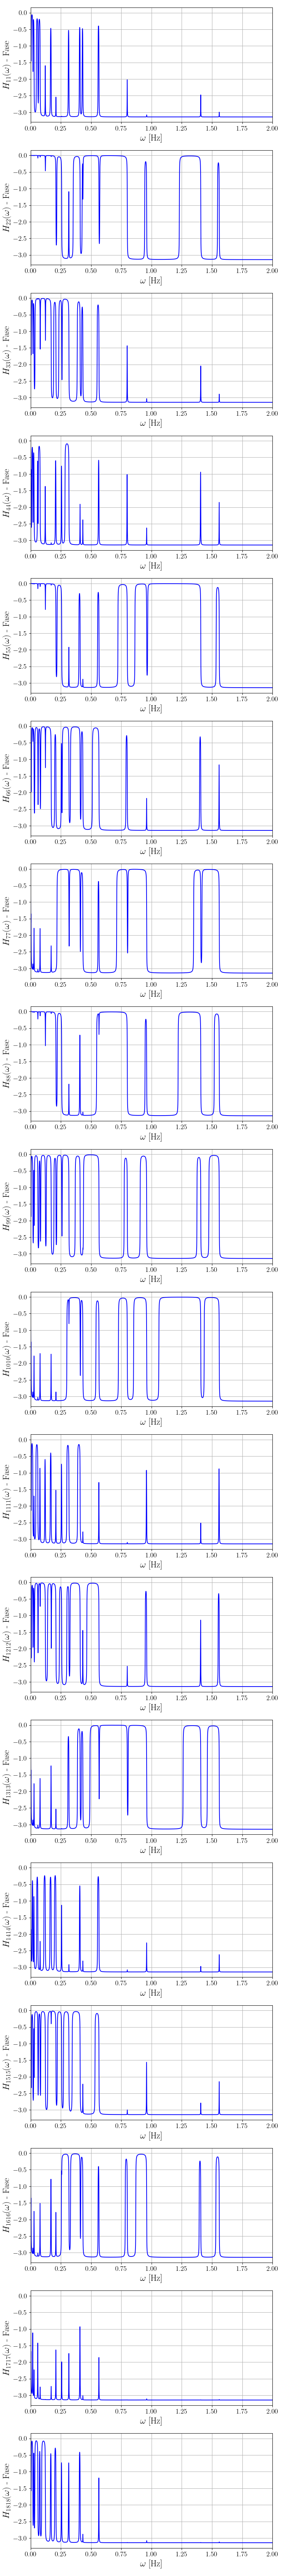

In [460]:
def plot_n_phase(f2, H, diagonal_only=False, figsize=(6, 6), xlim=(0, 50), **plot_kwargs):
    """
    Plota a fase das funções de resposta em frequência (FRF) para um sistema de n graus de liberdade.

    Parâmetros:
    -----------
    f2 : array-like
        Frequências em Hz.
    H : array-like
        Matriz de funções de resposta em frequência (FRF) complexas, onde H[i, j, :] representa a FRF entre o i-ésimo e j-ésimo graus de liberdade.
    figsize : tuple, opcional
        Tamanho da figura (largura, altura) em polegadas. O padrão é (14, 6).

    Retorna:
    --------
    None
        A função não retorna nada. Ela exibe um gráfico com as fases das FRFs.
    """
    n = len(H)
    default_kwargs = {"color": "b", "linestyle": "-"}
    final_kwargs = {**default_kwargs, **plot_kwargs}

    if diagonal_only:
        fig, ax = plt.subplots(n, 1, figsize=(figsize[0], n * figsize[1]), squeeze=False)
        ax = ax.flatten()
        for i in range(n):
            ax[i].grid(True)
            ax[i].plot(f2, np.angle(H[i, i, :]), **final_kwargs)
            ax[i].set(
                xlabel=r"$\omega$ [Hz]",
                ylabel=rf"$H_{{{i + 1}{i + 1}}}(\omega)$ - Fase",
                xlim=xlim,
            )
    else:
        fig, ax = plt.subplots(n, n, figsize=(n * figsize[0], n * figsize[1]))
        for i in range(n):
            for j in range(n):
                ax[i, j].grid(True)
                ax[i, j].plot(f2, np.angle(H[i, j, :]), **final_kwargs)
                ax[i, j].set(xlabel=r"$\omega$ [Hz]", ylabel=rf"$H_{{{i + 1}{j + 1}}}(\omega)$ - Fase", xlim=xlim)
    plt.tight_layout()
    plt.show()


plot_n_phase(w, Hw, diagonal_only=True, xlim=xlim, figsize=(8, 4))

#### Plots da parte imaginária

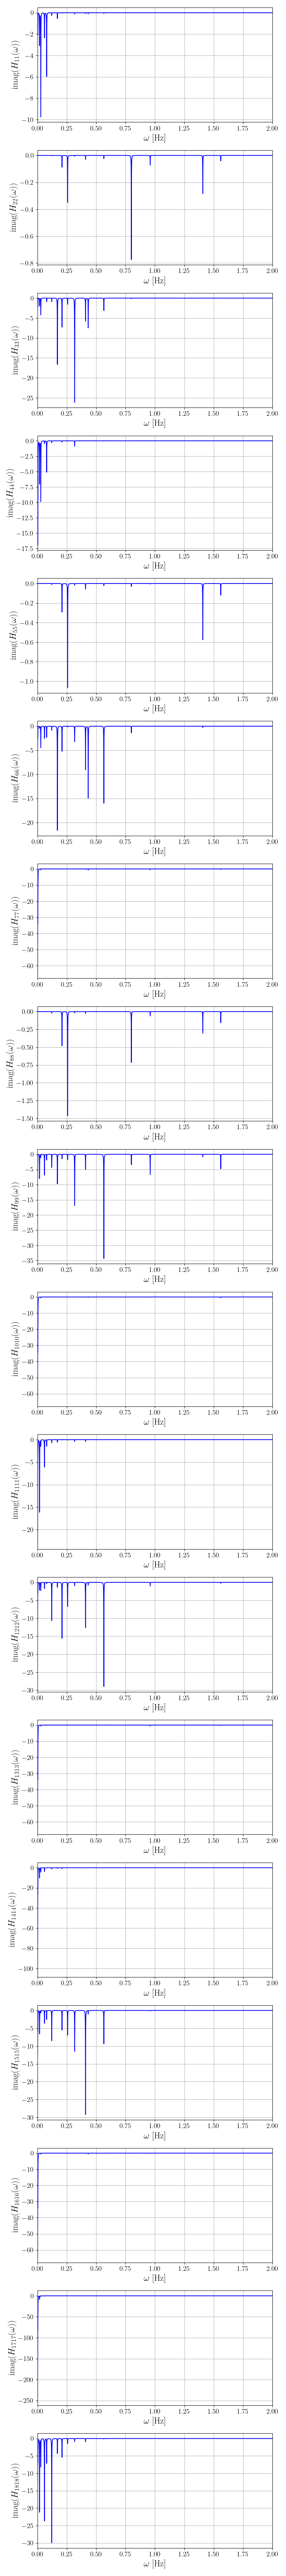

In [461]:
def plot_n_imaginary(f2, H, diagonal_only=False, figsize=(6, 6), xlim=(0, 50), **plot_kwargs):
    """
    Plota as partes imaginárias de uma matriz de funções de transferência.

    Parâmetros:
    f2 (array-like): Frequências em Hz.
    H (array-like): Matriz de funções de transferência complexas.
    figsize (tuple, opcional): Tamanho da figura (largura, altura). Padrão é (14, 6).
    diagonal_only (bool, opcional): Se True, plota apenas a diagonal principal de H. Padrão é False.

    Retorna:
    None
    """
    n = len(H)
    default_kwargs = {"color": "b", "linestyle": "-"}
    final_kwargs = {**default_kwargs, **plot_kwargs}  # Combina defaults com kwargs do usuário

    if diagonal_only:
        fig, ax = plt.subplots(n, 1, figsize=(figsize[0], n * figsize[1]), squeeze=False)
        ax = ax.flatten()
        for i in range(n):
            ax[i].grid(visible=True, which="major", axis="both")
            ax[i].plot(f2, np.imag(H[i, i, :]), **final_kwargs)
            ax[i].set(xlabel=r"$\omega$ [Hz]", ylabel=rf"imag($H_{{{i + 1}{i + 1}}}(\omega)$)", xlim=xlim)
    else:
        fig, ax = plt.subplots(n, n, figsize=(n * figsize[0], n * figsize[1]))
        for i in range(n):
            for j in range(n):
                ax[i, j].grid(visible=True, which="major", axis="both")
                ax[i, j].plot(f2, np.imag(H[i, j, :]), **final_kwargs)
                ax[i, j].set(xlabel=r"$\omega$ [Hz]", ylabel=rf"imag($H_{{{i + 1}{j + 1}}}(\omega)$)", xlim=xlim)
    plt.tight_layout()
    plt.show()


plot_n_imaginary(w, Hw, xlim=xlim, diagonal_only=True, figsize=(8, 4))

**Comentários:**
- É interessante observar que nos primeiros picos, os graus de liberdade referentes a translação vertical não são excitados.

# !!!! FALTA ACERTAR !!!!

### Estimando parâmetros a partir da FRF utilizando modelo Modal (Line-fit)

In [462]:
def estimate_delta(ww_local, H_local, Omega):
    """
    Calcula o vetor delta para o método line-fit (Dobson's method).

    Parâmetros:
    ww_local (np.array): Vetor de frequências angulares [rad/s] da região de interesse
    H_local (np.array): Vetor complexo com a FRF correspondente às frequências ww_local
    Omega (float): Frequência angular específica para cálculo do delta

    Retorna:
    tuple: (ww_delta, delta)
        ww_delta (np.array): Frequências utilizadas no cálculo
        delta (np.array): Valores calculados de delta para a frequência Omega
    """
    index_Omega = np.where(ww_local == Omega)[0][0]
    H_omega = H_local[index_Omega,]
    Den = []
    Num = []
    ww_delta = []
    for index in range(0, len(ww_local)):
        if index == index_Omega:
            continue
        else:
            Den.append(H_local[index,] - H_omega)
            Num.append(ww_local[index,] ** 2 - Omega**2)
            ww_delta.append(ww_local[index,])
    Den = np.asarray(Den, dtype="complex")
    Num = np.asarray(Num, dtype="complex")
    ww_delta = np.asarray(ww_delta)
    delta = Num.reshape(
        -1,
    ) / Den.reshape(
        -1,
    )
    # print(delta)
    return ww_delta, delta


def moindre_carre(x, y):
    """
    Realiza regressão linear por mínimos quadrados para y = a*x + b.

    Parâmetros:
    x (np.array): Variável independente
    y (np.array): Variável dependente

    Retorna:
    tuple: (a, b) - coeficientes angular e linear da reta
    """
    N = len(x)
    Sx = np.sum(x)
    Sy = np.sum(y)
    Sxx = np.sum(x * x)
    Sxy = np.sum(x * y)
    b = (Sxx * Sy - Sx * Sxy) / (N * Sxx - Sx**2)
    a = (N * Sxy - Sx * Sy) / (N * Sxx - Sx**2)
    return a, b


def line_fit(H_exp, freq, fmin, fmax):
    """
    Estima parâmetros modais usando o método line-fit de Dobson em um intervalo de frequência.

    Parâmetros:
    H_exp (np.array): FRF experimental (array complexo)
    freq (np.array): Vetor de frequências em Hz
    fmin (float): Frequência mínima do intervalo de análise
    fmax (float): Frequência máxima do intervalo de análise

    Retorna:
    tuple: (zeta, wr, B)
        zeta (float): Fator de amortecimento (loss_factor/2)
        wr (float): Frequência natural em rad/s
        B (complex): Constante modal complexa

    Nota:
    - O intervalo [fmin, fmax] deve conter preferencialmente apenas um modo vibratório
    - A qualidade dos resultados depende da seleção adequada do intervalo de frequência
    """

    temp = np.argwhere(freq > fmin)  # Find the indices of array elements that are non-zero, grouped by element.
    index_low = temp[0, 0] - 1
    temp = np.argwhere(freq > fmax)  # Find the indices of array elements that are non-zero, grouped by element.
    index_high = temp[0, 0]

    H_local = H_exp[index_low:index_high]
    freq_local = freq[index_low:index_high]
    ww_local = 2 * np.pi * freq_local

    # In the case of insufficient number of samples
    N_pts = len(freq_local)
    Delta = np.zeros((N_pts - 1, N_pts), dtype="complex")
    ww_Delta = np.zeros((N_pts - 1, N_pts))

    # Dobson's method application
    for ind in range(0, N_pts):
        ww_delta, delta = estimate_delta(ww_local, H_local, ww_local[ind])
        Delta[:, ind] = delta
        ww_Delta[:, ind] = ww_delta

    tr = np.zeros((N_pts,))
    cr = np.zeros((N_pts,))
    ti = np.zeros((N_pts,))
    ci = np.zeros((N_pts,))

    # Best straight line finding
    for index in range(N_pts):
        a, b = moindre_carre(ww_Delta[:, index] ** 2, np.real(Delta[:, index]))
        tr[index,] = a
        cr[index,] = b
        a, b = moindre_carre(ww_Delta[:, index] ** 2, np.imag(Delta[:, index]))
        ti[index,] = a
        ci[index,] = b

    ur, dr = moindre_carre(ww_local**2, tr)
    ui, di = moindre_carre(ww_local**2, ti)
    p = ui / ur
    q = di / dr

    # Modal parameters calculation
    loss_factor = (q - p) / (1 + p * q)
    wr = np.sqrt(dr / ((p * loss_factor - 1) * ur))
    ar = -(wr**2) * (p * loss_factor - 1) / ((1 + p**2) * dr)
    br = ar * p
    B = ar + 1j * br

    # loss_factor/2: fator de amortecimento
    # wr: frequência natural
    # B: constante modal para o modo estudado (muda conforme mudo a posição entrada-saída)

    return (loss_factor / 2, wr, B)

In [463]:
def automatic_modal_estimation(H, freq, ref_dof=(0, 0), delta_points=10):
    """
    Realiza estimativa modal automática usando detecção de picos e método line-fit.

    Parâmetros:
    H_exp (np.ndarray): Array 3D de FRFs (saída x entrada x frequência)
    freq (np.array): Vetor de frequências em Hz
    ref_dof (tuple): Grau de liberdade de referência para detecção de picos (input, output)
    delta_points (int): Número de pontos ao redor do pico para análise (padrão=10)

    Retorna:
    list: Lista de dicionários com parâmetros modais para cada modo detectado

    Cada dicionário na lista contém:
    - 'zeta': Fator de amortecimento
    - 'wn': Frequência natural em Hz
    - 'Aij': Constantes modais para cada grau de liberdade

    Fluxo do método:
    1. Detecta picos na FRF de referência usando find_peaks
    2. Define intervalos de análise ao redor de cada pico
    3. Aplica line-fit para cada modo em todos os graus de liberdade
    4. Consolida resultados em estrutura padronizada

    Exemplo de uso:
    >>> resultados = automatic_modal_estimation(H_exp, w, ref_dof=(0,0), delta_points=15)
    """
    # Verificação inicial de H
    if not isinstance(H, np.ndarray) or H.ndim != 3:
        raise ValueError("H deve ser um array 3D (saída x entrada x frequência)")

    # Detecção de picos com parâmetros ajustáveis
    ref_H = H[ref_dof[0], ref_dof[1], :].flatten()
    magnitude = np.abs(ref_H)

    # Ajustar parâmetros de detecção de picos
    peaks, _ = find_peaks(
        magnitude,
        prominence=np.max(magnitude) * 0.1,  # 10% do pico máximo
        distance=delta_points * 2,
    )

    # Verificar se há picos detectados
    if len(peaks) == 0:
        raise ValueError("Nenhum pico detectado na FRF de referência. Verifique os dados e parâmetros.")

    # Determinar intervalos de frequência válidos
    mode_ranges = []
    for peak_idx in peaks:
        if peak_idx < delta_points or peak_idx >= len(freq) - delta_points:
            continue  # Ignorar picos próximos às bordas
        start = peak_idx - delta_points
        end = peak_idx + delta_points
        mode_ranges.append((freq[start], freq[end]))

    # Verificar intervalos válidos
    if not mode_ranges:
        raise ValueError("Nenhum intervalo de modo válido detectado")

    results = []
    for i, (fmin, fmax) in enumerate(mode_ranges):
        print(f"\n############ Modo {i + 1} ##############")
        print(f"Intervalo de frequência: {fmin:.3f} Hz - {fmax:.3f} Hz")

        modal_params = {"zeta": None, "wn": None}
        valid_mode = False

        for dof in range(H.shape[0]):
            try:
                H_dof = H[dof, dof, :].reshape(-1, 1)
                zeta, wn, A = line_fit(H_dof, freq, fmin, fmax)

                # Primeiro grau define parâmetros globais
                if dof == 0:
                    modal_params["zeta"] = float(zeta[0])
                    modal_params["wn"] = float(wn[0]) / (2 * np.pi)
                    valid_mode = True

                modal_params[f"A{dof + 1}{dof + 1}"] = float(A[0])

            except Exception as e:
                print(f"Erro no grau {dof + 1}: {str(e)}")
                continue

        # Só adicionar se parâmetros essenciais foram encontrados
        if valid_mode:
            results.append(modal_params)
            print(f"Frequência Natural: {modal_params['wn']:.2f} Hz")
            print(f"Fator de Amortecimento: {modal_params['zeta']:.4f}")
            for key in [k for k in modal_params if "A" in k]:
                print(f"{key}: {modal_params[key]:.4e}")
        else:
            print(f"Modo {i + 1} descartado - parâmetros essenciais não encontrados")

    return results


resultados = automatic_modal_estimation(Hw, w, ref_dof=(0, 0), delta_points=15)


############ Modo 1 ##############
Intervalo de frequência: 0.017 Hz - 0.019 Hz
Erro no grau 1: invalid index to scalar variable.
Erro no grau 2: invalid index to scalar variable.
Erro no grau 3: invalid index to scalar variable.
Erro no grau 4: invalid index to scalar variable.
Erro no grau 5: invalid index to scalar variable.
Erro no grau 6: invalid index to scalar variable.
Erro no grau 7: invalid index to scalar variable.
Erro no grau 8: invalid index to scalar variable.
Erro no grau 9: invalid index to scalar variable.
Erro no grau 10: invalid index to scalar variable.
Erro no grau 11: invalid index to scalar variable.
Erro no grau 12: invalid index to scalar variable.
Erro no grau 13: invalid index to scalar variable.
Erro no grau 14: invalid index to scalar variable.
Erro no grau 15: invalid index to scalar variable.
Erro no grau 16: invalid index to scalar variable.
Erro no grau 17: invalid index to scalar variable.
Erro no grau 18: invalid index to scalar variable.
Modo 1 des

## Projeto do Absorvedor

In [464]:
w

array([0.0000e+00, 1.0000e-04, 2.0000e-04, ..., 4.9997e+00, 4.9998e+00,
       4.9999e+00], shape=(50000,))

In [465]:
# %%
fi = int(np.where(w == 0.002)[0])  # posição do vetor inicial
ff = int(np.where(w == 0.004)[0])  # posição do vetor final
inp = 15
out = 15
fwn = fi + np.argmax(np.abs(Hw[out, inp, fi:ff]))
wn1 = 2 * np.pi * w[fwn]
print("wn1 = ", wn1 / 2 / np.pi, " Hz")

# Meia potência
Bandwith = np.max(np.abs(Hw[out, inp, fi:ff])) / np.sqrt(2)
w1 = 2 * np.pi * w[fi + np.abs(np.abs(Hw[out, inp, fi:fwn]) - Bandwith).argmin()]
w2 = 2 * np.pi * w[fwn + np.abs(np.abs(Hw[out, inp, fwn:ff]) - Bandwith).argmin()]
zeta1 = (w2 - w1) / (2 * wn1)
print("zeta1 = ", zeta1)

# Constante modal
Aabs_modo1 = np.max(np.abs(Hw[out, inp, fi:ff])) * 2 * zeta1 * wn1**2
m_estrutura = 1 / Aabs_modo1
no_abs = total_nos // 2
print(f"A({no_abs},{no_abs})1 = ", Aabs_modo1)
print(f"m1 modal exp ({no_abs}-{no_abs}) = ", m_estrutura)


wn1 =  0.0035  Hz
zeta1 =  0.2
A(3,3)1 =  0.006627618222726947
m1 modal exp (3-3) =  150.88376644431216


C:\Users\Admin\AppData\Local\Temp\ipykernel_21312\2295047583.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fi = int(np.where(w == 0.002)[0])  # posição do vetor inicial
C:\Users\Admin\AppData\Local\Temp\ipykernel_21312\2295047583.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ff = int(np.where(w == 0.004)[0])  # posição do vetor final


In [466]:
# %%
# Projeto do absorvedor
mu = 0.05
m_absorvedor = mu * m_estrutura
print("Massa do absorvedor [kg]: ", m_absorvedor)
w_absorvedor = wn1 / (1 + mu)
k_absorvedor = m_absorvedor * w_absorvedor**2
zeta_absorvedor = np.sqrt(3 * mu / 8 / (1 + mu) ** 3)
print("zeta do absorvedor: ", zeta_absorvedor)
c_absorvedor = 2 * zeta_absorvedor * w_absorvedor * m_absorvedor

Massa do absorvedor [kg]:  7.544188322215608
zeta do absorvedor:  0.12726725805353542


In [467]:
# Adicionando as matrizes (novo sistema)
M_absorvedor = np.zeros((len(M) + 1, len(M) + 1))
K_absorvedor = np.zeros((len(M) + 1, len(M) + 1))
C_absorvedor = np.zeros((len(M) + 1, len(M) + 1))

M_absorvedor[0 : len(M), 0 : len(M)] = np.zeros((len(M), len(M))) + M
K_absorvedor[0 : len(M), 0 : len(M)] = np.zeros((len(M), len(M))) + K
C_absorvedor[0 : len(M), 0 : len(M)] = np.zeros((len(M), len(M))) + C

M_absorvedor[-1, -1] = M_absorvedor[-1, -1] + m_absorvedor

gdl_absorvedor = (3 * (total_nos // 2)) + 1
K_absorvedor[-1, -1] = K_absorvedor[-1, -1] + k_absorvedor
K_absorvedor[gdl_absorvedor, gdl_absorvedor] = K_absorvedor[gdl_absorvedor, gdl_absorvedor] + k_absorvedor
K_absorvedor[-1, gdl_absorvedor] = K_absorvedor[-1, gdl_absorvedor] - k_absorvedor
K_absorvedor[gdl_absorvedor, -1] = K_absorvedor[gdl_absorvedor, -1] - k_absorvedor

C_absorvedor[-1, -1] = C_absorvedor[-1, -1] + c_absorvedor
C_absorvedor[gdl_absorvedor, gdl_absorvedor] = C_absorvedor[gdl_absorvedor, gdl_absorvedor] + c_absorvedor
C_absorvedor[-1, gdl_absorvedor] = C_absorvedor[-1, gdl_absorvedor] - c_absorvedor
C_absorvedor[gdl_absorvedor, -1] = C_absorvedor[gdl_absorvedor, -1] - c_absorvedor

C:\Users\Admin\AppData\Local\Temp\ipykernel_21312\3711369113.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0, 0].set(xlim=xlim)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21312\3711369113.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1, 0].set(xlim=xlim)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21312\3711369113.py:27: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0, 1].set(xlim=xlim)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21312\3711369113.py:36: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1, 1].set(xlim=xlim)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21312\3711369113.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0, 2].set(xlim=xlim)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21312\3711369113.py:49: UserWarning: Attempt to set non-positive x

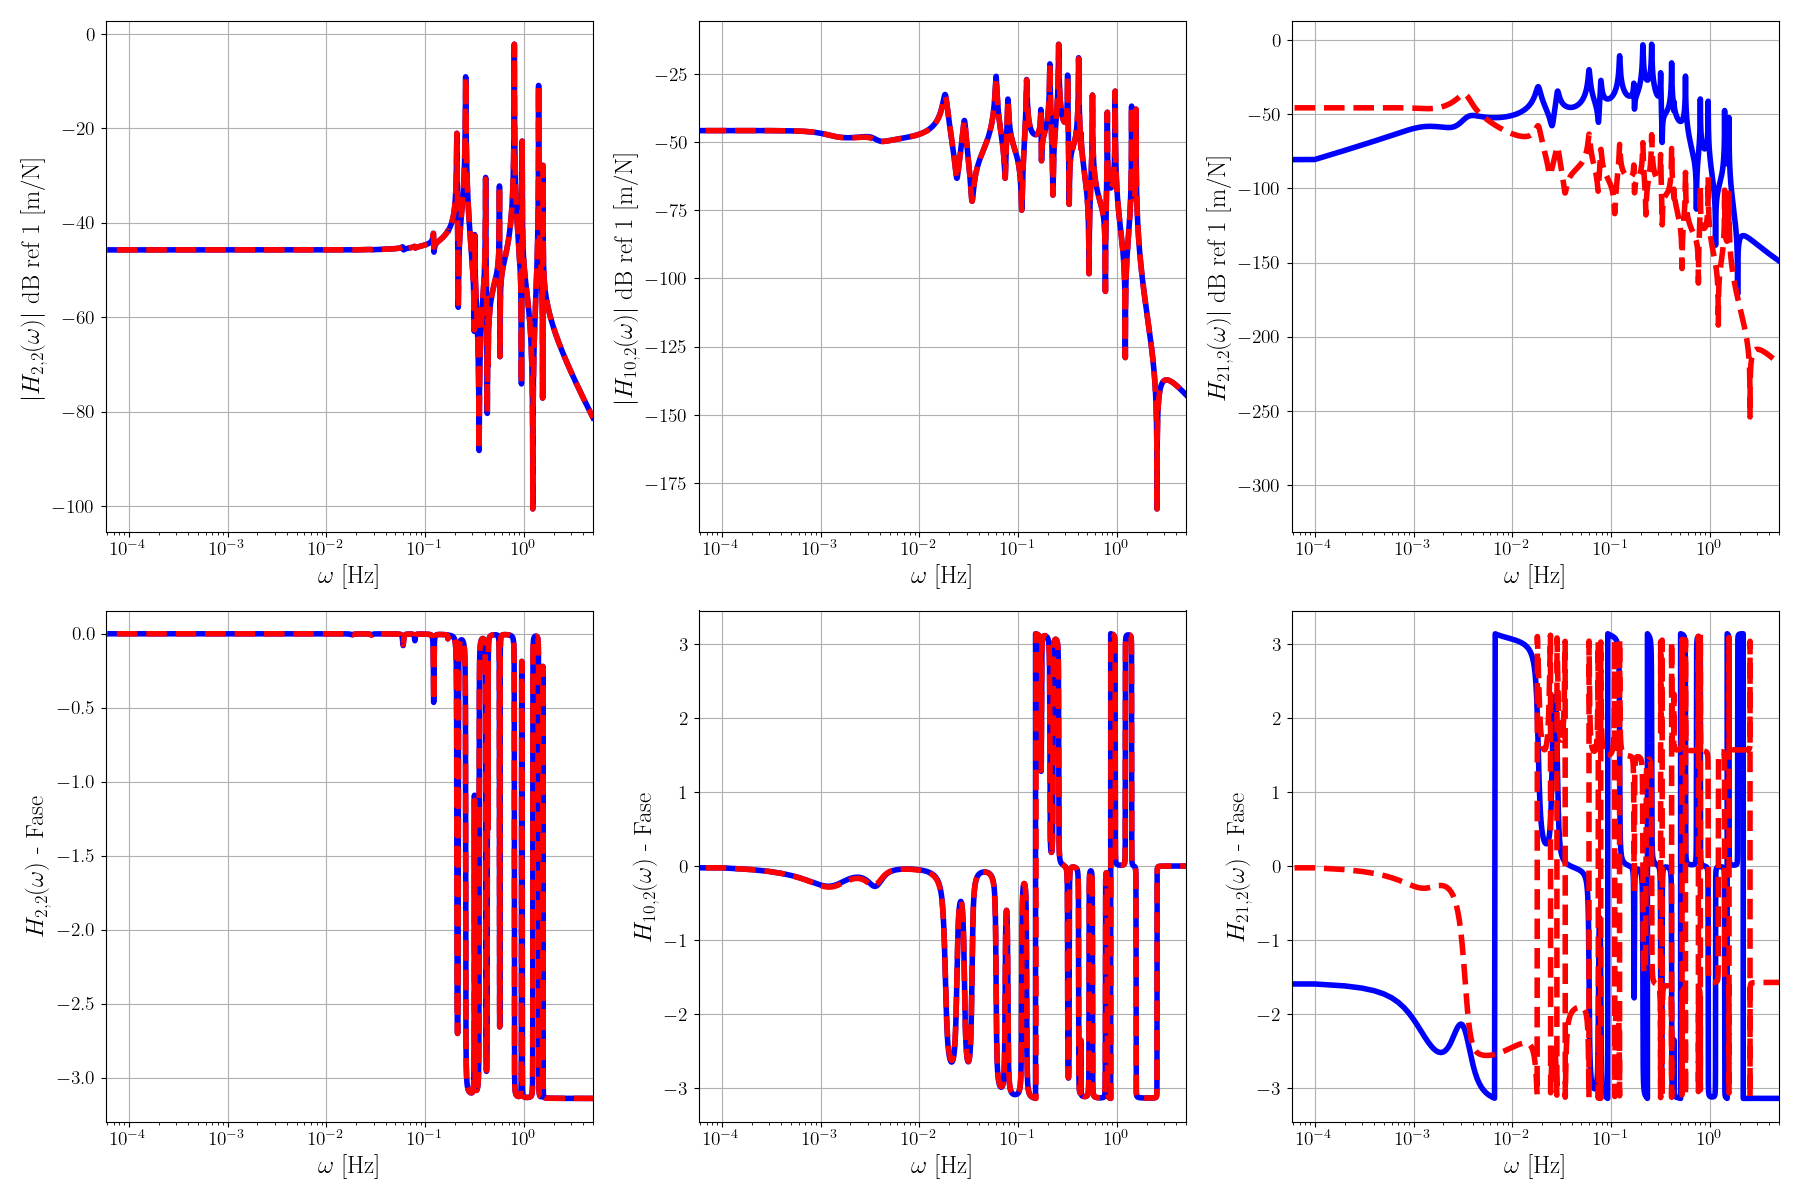

In [ ]:
# %%
H_absorvedor = np.zeros((len(M) + 1, len(M) + 1, len(w)), dtype="complex")
for n in range(0, len(w)):
    H_absorvedor[:, :, n] = np.linalg.inv(
        K_absorvedor - M_absorvedor * ((2 * np.pi * w[n]) ** 2) + complex(0, 1) * C_absorvedor * 2 * np.pi * w[n]
    )  # Calcula as 4 componentes de H analiticamente
xlim = (0, 5)
# %%
fig, ax = plt.subplots(2, 3, figsize=(3 * 6, 2 * 6))
ax[0, 0].grid(visible=True, which="major", axis="x")
ax[0, 0].grid(visible=True, which="major", axis="y")
ax[0, 0].semilogx(w, 20 * np.log10(abs(Hw[1, 1, :])), "b", linewidth=4)
ax[0, 0].semilogx(w, 20 * np.log10(abs(H_absorvedor[1, 1, :])), "--r", linewidth=4)
ax[0, 0].set(xlim=xlim)
ax[0, 0].set(xlabel=r"$\omega$ [Hz]", ylabel=r"$|H_{2,2} (\omega)|$ dB ref 1 [m/N] ")
ax[1, 0].grid(visible=True, which="major", axis="y")
ax[1, 0].grid(visible=True, which="major", axis="x")
ax[1, 0].semilogx(w, np.angle(Hw[1, 1, :]), "b", linewidth=4)
ax[1, 0].semilogx(w, np.angle(H_absorvedor[1, 1, :]), "--r", linewidth=4)
ax[1, 0].set(xlim=xlim)
ax[1, 0].set(xlabel=r"$\omega$ [Hz]", ylabel=r"$H_{2,2} (\omega)$ - Fase ")

ax[0, 1].grid(visible=True, which="major", axis="y")
ax[0, 1].grid(visible=True, which="major", axis="x")
ax[0, 1].semilogx(w, 20 * np.log10(abs(Hw[gdl_absorvedor, 1, :])), "b", linewidth=4)
ax[0, 1].semilogx(w, 20 * np.log10(abs(H_absorvedor[gdl_absorvedor, 1, :])), "--r", linewidth=4)
ax[0, 1].set(xlim=xlim)
ax[0, 1].set(
    xlabel=r"$\omega$ [Hz]",
    ylabel=r"$|H_{" + f"{gdl_absorvedor}" + ",2} (\omega)|$ dB ref 1 [m/N]",
)
ax[1, 1].grid(visible=True, which="major", axis="y")
ax[1, 1].grid(visible=True, which="major", axis="x")
ax[1, 1].semilogx(w, np.angle(Hw[gdl_absorvedor, 1, :]), "b", linewidth=4)
ax[1, 1].semilogx(w, np.angle(H_absorvedor[gdl_absorvedor, 1, :]), "--r", linewidth=4)
ax[1, 1].set(xlim=xlim)
ax[1, 1].set(xlabel=r"$\omega$ [Hz]", ylabel=r"$H_{" + f"{gdl_absorvedor}" + ",2} (\omega)$ - Fase ")

ax[0, 2].grid(visible=True, which="major", axis="y")
ax[0, 2].grid(visible=True, which="major", axis="x")
ax[0, 2].semilogx(w, 20 * np.log10(abs(Hw[-1, 1, :])), "b", linewidth=4)
ax[0, 2].semilogx(w, 20 * np.log10(abs(H_absorvedor[-1, 1, :])), "--r", linewidth=4)
ax[0, 2].set(xlim=xlim)
ax[0, 2].set(xlabel=r"$\omega$ [Hz]", ylabel=r"$H_{" + f"{total_dofs}" + ",2} (\omega)|$ dB ref 1 [m/N] ")
ax[1, 2].grid(visible=True, which="major", axis="y")
ax[1, 2].grid(visible=True, which="major", axis="x")
ax[1, 2].semilogx(w, np.angle(Hw[-1, 1, :]), "b", linewidth=4)
ax[1, 2].semilogx(w, np.angle(H_absorvedor[-1, 1, :]), "--r", linewidth=4)
ax[1, 2].set(xlim=xlim)
ax[1, 2].set(xlabel=r"$\omega$ [Hz]", ylabel=r"$H_{" + f"{total_dofs}" + ",2} (\omega)$ - Fase ")
plt.show()


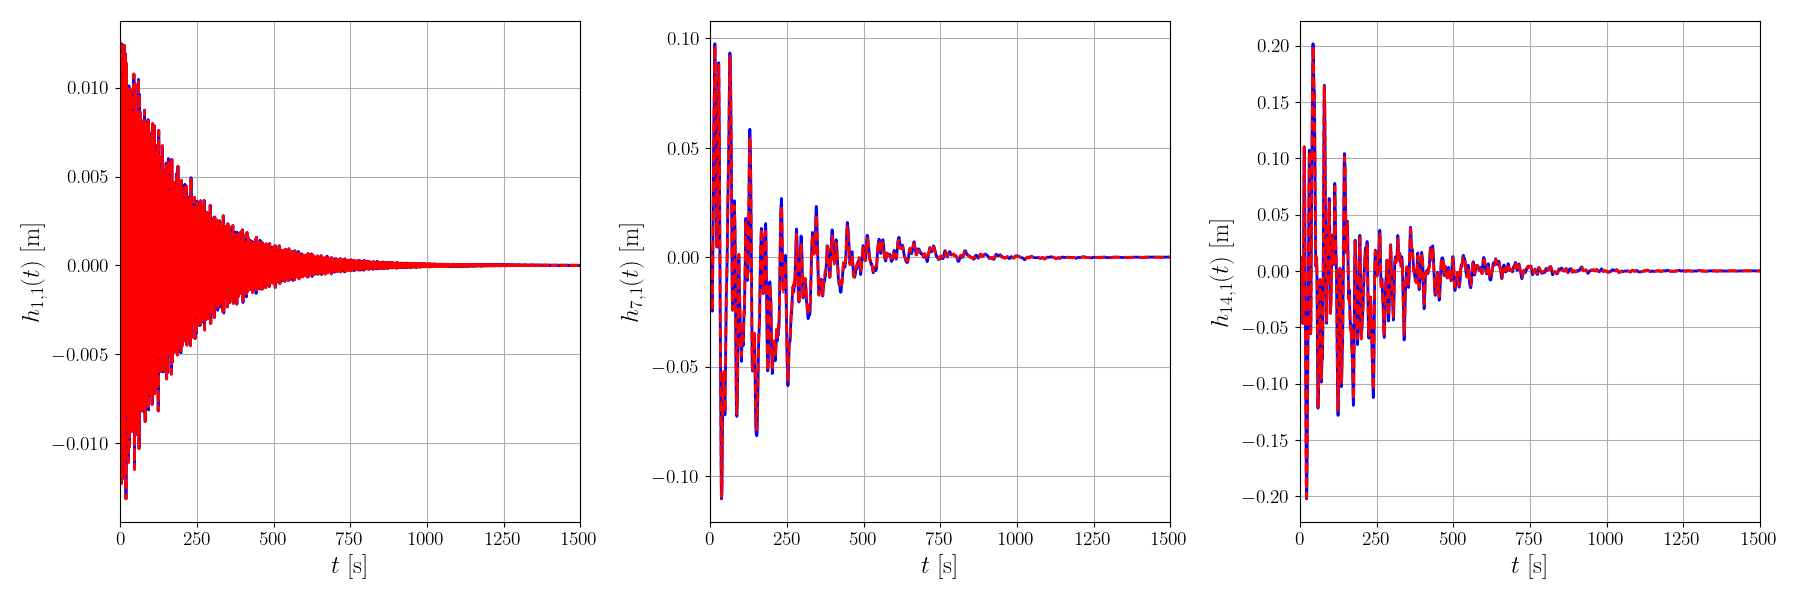

In [ ]:
Hd = np.concatenate((Hw[1, 1, :], np.conj(Hw[1, 1, Np:0:-1])), axis=0)  # [m/N]
h = fs * np.real(fft.ifft(Hd))  # [m/Ns]
h11 = h[0:Np]

Hd = np.concatenate((H_absorvedor[1, 1, :], np.conj(H_absorvedor[1, 1, Np:0:-1])), axis=0)  # [m/N]
h = fs * np.real(fft.ifft(Hd))  # [m/Ns]
h11_absorvedor = h[0:Np]

Hd = np.concatenate((Hw[0, gdl_absorvedor, :], np.conj(Hw[0, gdl_absorvedor, Np:0:-1])), axis=0)  # [m/N]
h = fs * np.real(fft.ifft(Hd))  # [m/Ns]
h71 = h[0:Np]

Hd = np.concatenate(
    (H_absorvedor[0, gdl_absorvedor, :], np.conj(H_absorvedor[0, gdl_absorvedor, Np:0:-1])), axis=0
)  # [m/N]
h = fs * np.real(fft.ifft(Hd))  # [m/Ns]
h71_absorvedor = h[0:Np]

Hd = np.concatenate((Hw[0, total_dofs - 4, :], np.conj(Hw[0, total_dofs - 4, Np:0:-1])), axis=0)  # [m/N]
h = fs * np.real(fft.ifft(Hd))  # [m/Ns]
h141 = h[0:Np]

Hd = np.concatenate(
    (H_absorvedor[0, total_dofs - 4, :], np.conj(H_absorvedor[0, total_dofs - 4, Np:0:-1])), axis=0
)  # [m/N]
h = fs * np.real(fft.ifft(Hd))  # [m/Ns]
h141_absorvedor = h[0:Np]

# %%
fig, ax = plt.subplots(1, 3, figsize=(3 * 6, 6))
ax[0].plot(t[:-1], h11, "b", linewidth=2)
ax[0].plot(t[:-1], h11_absorvedor, "--r", linewidth=2)
ax[0].grid(visible=True, which="major", axis="both")
ax[0].set_xlim([0, 1500])
ax[0].set_xlabel("$t$ [s]")
ax[0].set_ylabel("$h_{1,1}(t)$ [m]")
ax[1].plot(t[:-1], h71, "b", linewidth=2)
ax[1].plot(t[:-1], h71_absorvedor, "--r", linewidth=2)
ax[1].grid(visible=True, which="major", axis="both")
ax[1].set_xlim([0, 1500])
ax[1].set_xlabel("$t$ [s]")
ax[1].set_ylabel("$h_{7,1}(t)$ [m]")
ax[2].plot(t[:-1], h141, "b", linewidth=2)
ax[2].plot(t[:-1], h141_absorvedor, "--r", linewidth=2)
ax[2].grid(visible=True, which="major", axis="both")
ax[2].set_xlim([0, 1500])
ax[2].set_xlabel("$t$ [s]")
ax[2].set_ylabel("$h_{14,1}(t)$ [m]")
plt.show()
